In [163]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [164]:
pd.options.display.float_format = '{:.1f}'.format

In [165]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [166]:
#各クラスの特徴ベクトルの配列の列数を格納した配列を引数にすればもう少し拡張性が上がる
def SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index):
    λ_1 = 0.04
    λ_2 = 0.06
    answer = np.zeros(feat_l_te.shape[1])
    SGRM_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        u = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)
                                +λ_1*cv.norm(u[:,0],1)
                                +λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                                      +cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic.shape[0],0],2)))
                                     #+cv.norm(u[feat_tr_dic_4.shape[0]:feat_tr_dic_5.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_5.shape[0]:feat_tr_dic_6.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_6.shape[0]:feat_tr_dic.shape[0],0],2)))
        constraints = [u == 0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)+λ_1*cv.norm(u[:,0],1)
                       +λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                             +cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                             +cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                             +cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic.shape[0],0],2))]
                             #+cv.norm(u[feat_tr_dic_3.shape[0]:feat_tr_dic.shape[0],0],2))] 
                    
        prob = cv.Problem(objective)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SGRM_Cla[:,i] = np.squeeze(u.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SGRM_l_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SGRM_r_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SGRM_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SGRM_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [167]:
def SGRM_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")

    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic = Dic(feat_tr_dic_2,feat_tr_K3).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0]])
    answer1 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [168]:
name1 = ["1","2","3","4","5","6"]
name2 = ["1","2","3"]
feature1 = ["全体","左","右"]
feature2 = ["全体","右","足"]

In [169]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_test_left_A01E.txt","feat_2a_250Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_test_left_A02E.txt","feat_2a_250Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_20/feat_test_left_A03E.txt","feat_2a_250Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_20/feat_test_left_A07E.txt","feat_2a_250Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_20/feat_test_left_A08E.txt","feat_2a_250Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_20/feat_test_left_A09E.txt","feat_2a_250Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,50.0,4.0,96.0
2,61.0,78.0,44.0
3,50.0,2.0,98.0
4,59.0,54.0,64.0
5,50.0,100.0,0.0
6,48.0,16.0,80.0


In [170]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_test_left_A01E.txt","feat_2a_250Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_test_left_A02E.txt","feat_2a_250Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_20/feat_test_left_A03E.txt","feat_2a_250Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_20/feat_test_left_A07E.txt","feat_2a_250Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_20/feat_test_left_A08E.txt","feat_2a_250Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_20/feat_test_left_A09E.txt","feat_2a_250Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,48.0,6.0,90.0
2,60.0,80.0,40.0
3,48.0,0.0,96.0
4,55.0,40.0,70.0
5,50.0,100.0,0.0
6,50.0,4.0,96.0


In [171]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_test_left_A01E.txt","feat_2a_250Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_test_left_A02E.txt","feat_2a_250Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_20/feat_test_left_A03E.txt","feat_2a_250Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_30_3/feat_left_A07T_30.txt","feat_2a_250Hz_30_3/feat_right_A07T_30.txt","feat_2a_250Hz_20/feat_test_left_A07E.txt","feat_2a_250Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_20/feat_test_left_A08E.txt","feat_2a_250Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_20/feat_test_left_A09E.txt","feat_2a_250Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,51.0,6.0,96.0
2,57.0,88.0,26.0
3,50.0,0.0,100.0
4,40.0,48.0,32.0
5,50.0,100.0,0.0
6,53.0,6.0,100.0


In [172]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_250Hz,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,49.7,5.3,94.0
2,59.3,82.0,36.7
3,49.3,0.7,98.0
4,51.3,47.3,55.3
5,50.0,100.0,0.0
6,50.3,8.7,92.0


In [174]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_20/feat_test_left_A01E.txt","feat_2a_125Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_20/feat_test_left_A02E.txt","feat_2a_125Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_20/feat_test_left_A03E.txt","feat_2a_125Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_20/feat_test_left_A07E.txt","feat_2a_125Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_20/feat_test_left_A08E.txt","feat_2a_125Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_20/feat_test_left_A09E.txt","feat_2a_125Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,60.0,72.0,48.0
2,50.0,100.0,0.0
3,50.0,100.0,0.0
4,52.0,70.0,34.0
5,46.0,68.0,24.0
6,41.0,16.0,66.0


In [175]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_20/feat_test_left_A01E.txt","feat_2a_125Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_20/feat_test_left_A02E.txt","feat_2a_125Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_20/feat_test_left_A03E.txt","feat_2a_125Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_20/feat_test_left_A07E.txt","feat_2a_125Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_20/feat_test_left_A08E.txt","feat_2a_125Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_20/feat_test_left_A09E.txt","feat_2a_125Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,56.0,56.0,56.0
2,50.0,100.0,0.0
3,50.0,100.0,0.0
4,52.0,68.0,36.0
5,48.0,70.0,26.0
6,56.0,80.0,32.0


In [176]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_20/feat_test_left_A01E.txt","feat_2a_125Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_20/feat_test_left_A02E.txt","feat_2a_125Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_20/feat_test_left_A03E.txt","feat_2a_125Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_20/feat_test_left_A07E.txt","feat_2a_125Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_20/feat_test_left_A08E.txt","feat_2a_125Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_20/feat_test_left_A09E.txt","feat_2a_125Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,56.0,62.0,50.0
2,51.0,100.0,2.0
3,46.0,92.0,0.0
4,58.0,78.0,38.0
5,50.0,82.0,18.0
6,50.0,4.0,96.0


In [177]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_125Hz,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,57.3,63.3,51.3
2,50.3,100.0,0.7
3,48.7,97.3,0.0
4,54.0,72.0,36.0
5,48.0,73.3,22.7
6,49.0,33.3,64.7


In [178]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

51.666666666666664 51.22222222222223


[[57.33333333 50.33333333 48.66666667 54.         48.         49.        ]
 [49.66666667 59.33333333 49.33333333 51.33333333 50.         50.33333333]]


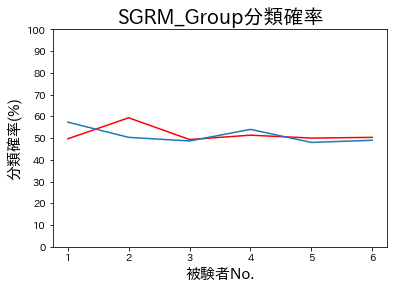

In [179]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SGRM_group_probability_K3.pdf")
plt.show()

In [181]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_20/feat_test_right_aa.txt","feat_4a_1000Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_20/feat_test_right_av.txt","feat_4a_1000Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_20/feat_test_right_aw.txt","feat_4a_1000Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,49.0,90.0,8.0
2,48.0,20.0,76.0
3,57.0,78.0,36.0


In [182]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_20/feat_test_right_aa.txt","feat_4a_1000Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_20/feat_test_right_av.txt","feat_4a_1000Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_20/feat_test_right_aw.txt","feat_4a_1000Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,50.0,96.0,4.0
2,50.0,50.0,50.0
3,58.0,100.0,16.0


In [183]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_20/feat_test_right_aa.txt","feat_4a_1000Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_20/feat_test_right_av.txt","feat_4a_1000Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_20/feat_test_right_aw.txt","feat_4a_1000Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,48.0,86.0,10.0
2,49.0,44.0,54.0
3,61.0,94.0,28.0


In [184]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_1000Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,49.0,90.7,7.3
2,49.0,38.0,60.0
3,58.7,90.7,26.7


In [185]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_20/feat_test_right_aa.txt","feat_4a_100Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_20/feat_test_right_av.txt","feat_4a_100Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_20/feat_test_right_aw.txt","feat_4a_100Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,52.0,68.0,36.0
2,48.0,60.0,36.0
3,51.0,88.0,14.0


In [186]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_20/feat_test_right_aa.txt","feat_4a_100Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_20/feat_test_right_av.txt","feat_4a_100Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_20/feat_test_right_aw.txt","feat_4a_100Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.0,78.0,22.0
2,50.0,100.0,0.0
3,56.0,70.0,42.0


In [187]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_20/feat_test_right_aa.txt","feat_4a_100Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_20/feat_test_right_av.txt","feat_4a_100Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_20/feat_test_right_aw.txt","feat_4a_100Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.0,64.0,36.0
2,36.0,26.0,46.0
3,53.0,82.0,24.0


In [188]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_100Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.7,70.0,31.3
2,44.7,62.0,27.3
3,53.3,80.0,26.7


In [189]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

52.22222222222222 49.55555555555555


[[50.66666667 44.66666667 53.33333333]
 [49.         49.         58.66666667]]


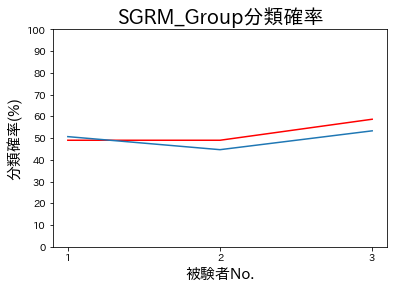

In [190]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SGRM_group_probability_K3.pdf")
plt.show()

In [191]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_10/feat_test_left_A01E.txt","feat_2a_250Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_10/feat_test_left_A02E.txt","feat_2a_250Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_10/feat_test_left_A03E.txt","feat_2a_250Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_10/feat_test_left_A07E.txt","feat_2a_250Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_10/feat_test_left_A08E.txt","feat_2a_250Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_10/feat_test_left_A09E.txt","feat_2a_250Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,51.0,78.0,24.0
2,52.0,100.0,4.0
3,65.0,94.0,36.0
4,54.0,44.0,64.0
5,70.0,72.0,68.0
6,54.0,58.0,50.0


In [192]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_10/feat_test_left_A01E.txt","feat_2a_250Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_10/feat_test_left_A02E.txt","feat_2a_250Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_10/feat_test_left_A03E.txt","feat_2a_250Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_10/feat_test_left_A07E.txt","feat_2a_250Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_10/feat_test_left_A08E.txt","feat_2a_250Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_10/feat_test_left_A09E.txt","feat_2a_250Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,51.0,52.0,50.0
2,52.0,24.0,80.0
3,66.0,74.0,58.0
4,49.0,60.0,38.0
5,49.0,20.0,78.0
6,61.0,88.0,34.0


In [193]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_10/feat_test_left_A01E.txt","feat_2a_250Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_10/feat_test_left_A02E.txt","feat_2a_250Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_10/feat_test_left_A03E.txt","feat_2a_250Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_10/feat_test_left_A07E.txt","feat_2a_250Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_10/feat_test_left_A08E.txt","feat_2a_250Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_10/feat_test_left_A09E.txt","feat_2a_250Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,51.0,64.0,38.0
2,50.0,100.0,0.0
3,64.0,70.0,58.0
4,51.0,54.0,48.0
5,54.0,14.0,94.0
6,53.0,96.0,10.0


In [194]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_250Hz,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,51.0,64.7,37.3
2,51.3,74.7,28.0
3,65.0,79.3,50.7
4,51.3,52.7,50.0
5,57.7,35.3,80.0
6,56.0,80.7,31.3


In [195]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_10/feat_test_left_A01E.txt","feat_2a_125Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_10/feat_test_left_A02E.txt","feat_2a_125Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_10/feat_test_left_A03E.txt","feat_2a_125Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_10/feat_test_left_A07E.txt","feat_2a_125Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_10/feat_test_left_A08E.txt","feat_2a_125Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_10/feat_test_left_A09E.txt","feat_2a_125Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,46.0,82.0,10.0
2,56.0,34.0,78.0
3,53.0,30.0,76.0
4,56.0,54.0,58.0
5,56.0,20.0,92.0
6,62.0,50.0,74.0


In [196]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_10/feat_test_left_A01E.txt","feat_2a_125Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_10/feat_test_left_A02E.txt","feat_2a_125Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_10/feat_test_left_A03E.txt","feat_2a_125Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_10/feat_test_left_A07E.txt","feat_2a_125Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_10/feat_test_left_A08E.txt","feat_2a_125Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_10/feat_test_left_A09E.txt","feat_2a_125Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,36.0,52.0,20.0
2,53.0,44.0,62.0
3,53.0,52.0,54.0
4,49.0,4.0,94.0
5,61.0,56.0,66.0
6,53.0,64.0,42.0


In [197]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_10/feat_test_left_A01E.txt","feat_2a_125Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_10/feat_test_left_A02E.txt","feat_2a_125Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_10/feat_test_left_A03E.txt","feat_2a_125Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_10/feat_test_left_A07E.txt","feat_2a_125Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_10/feat_test_left_A08E.txt","feat_2a_125Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_10/feat_test_left_A09E.txt","feat_2a_125Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,50.0,100.0,0.0
2,54.0,40.0,68.0
3,56.0,84.0,28.0
4,55.0,88.0,22.0
5,61.0,38.0,84.0
6,53.0,6.0,100.0


In [198]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_125Hz,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,44.0,78.0,10.0
2,54.3,39.3,69.3
3,54.0,55.3,52.7
4,53.3,48.7,58.0
5,59.3,38.0,80.7
6,56.0,40.0,72.0


In [199]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

55.38888888888889 53.5


[[44.         54.33333333 54.         53.33333333 59.33333333 56.        ]
 [51.         51.33333333 65.         51.33333333 57.66666667 56.        ]]


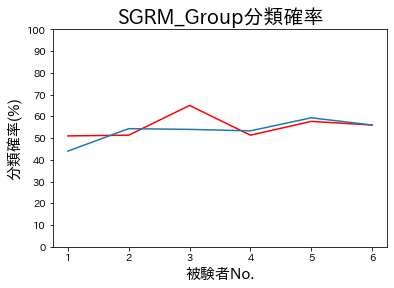

In [200]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SGRM_group_probability_K3_down.pdf")
plt.show()

In [201]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_10/feat_test_right_aa.txt","feat_4a_1000Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_10/feat_test_right_av.txt","feat_4a_1000Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_10/feat_test_right_aw.txt","feat_4a_1000Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,右,足
1,46.0,42.0,50.0
2,60.0,74.0,46.0
3,52.0,38.0,66.0


In [202]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_10/feat_test_right_aa.txt","feat_4a_1000Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_10/feat_test_right_av.txt","feat_4a_1000Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_10/feat_test_right_aw.txt","feat_4a_1000Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,44.0,38.0,50.0
2,58.0,80.0,36.0
3,49.0,28.0,70.0


In [203]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_10/feat_test_right_aa.txt","feat_4a_1000Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_10/feat_test_right_av.txt","feat_4a_1000Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_10/feat_test_right_aw.txt","feat_4a_1000Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,右,足
1,46.0,42.0,50.0
2,57.0,76.0,38.0
3,57.0,64.0,50.0


In [204]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_1000Hz,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,45.3,40.7,50.0
2,58.3,76.7,40.0
3,52.7,43.3,62.0


In [205]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_10/feat_test_right_aa.txt","feat_4a_100Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_10/feat_test_right_av.txt","feat_4a_100Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_10/feat_test_right_aw.txt","feat_4a_100Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,右,足
1,53.0,38.0,68.0
2,58.0,44.0,72.0
3,49.0,86.0,12.0


In [206]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_10/feat_test_right_aa.txt","feat_4a_100Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_10/feat_test_right_av.txt","feat_4a_100Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_10/feat_test_right_aw.txt","feat_4a_100Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,57.0,52.0,62.0
2,60.0,36.0,84.0
3,57.0,72.0,42.0


In [207]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_10/feat_test_right_aa.txt","feat_4a_100Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_10/feat_test_right_av.txt","feat_4a_100Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_10/feat_test_right_aw.txt","feat_4a_100Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,右,足
1,52.0,38.0,66.0
2,50.0,0.0,100.0
3,50.0,84.0,16.0


In [208]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_100Hz,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,54.0,42.7,65.3
2,56.0,26.7,85.3
3,52.0,80.7,23.3


In [209]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

52.111111111111114 54.0


[[54.         56.         52.        ]
 [45.33333333 58.33333333 52.66666667]]


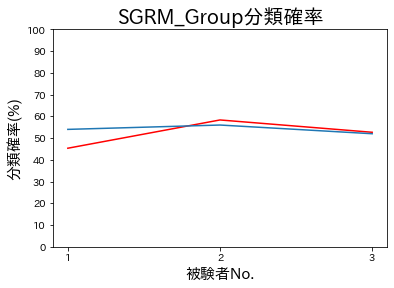

In [210]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SGRM_group_probability_K3_10.pdf")
plt.show()

In [145]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,50.0,0.0,100.0
2,50.0,96.0,4.0
3,50.0,0.0,100.0


In [146]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,50.0,0.0,100.0
2,47.0,4.0,90.0
3,51.0,100.0,2.0


In [147]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,50.0,100.0,0.0
2,49.0,94.0,4.0
3,52.0,4.0,100.0


In [148]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_250Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.0,33.3,66.7
2,48.7,92.7,4.7
3,50.7,1.3,100.0


In [149]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,53.0,100.0,6.0
2,52.0,100.0,4.0
3,58.0,46.0,70.0


In [150]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,57.0,94.0,20.0
2,52.0,100.0,4.0
3,50.0,0.0,100.0


In [151]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df        

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,50.0,100.0,0.0
2,51.0,98.0,4.0
3,50.0,2.0,98.0


In [152]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_125Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,53.3,98.0,8.7
2,51.7,99.3,4.0
3,52.7,16.0,89.3


In [153]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

49.77777777777777 52.55555555555555


In [154]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,48.0,84.0,12.0
2,50.0,100.0,0.0
3,50.0,100.0,0.0


In [155]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,57.0,56.0,58.0
2,49.0,4.0,94.0
3,45.0,76.0,14.0


In [156]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,48.0,60.0,36.0
2,50.0,0.0,100.0
3,50.0,100.0,0.0


In [157]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_250Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,51.0,66.7,35.3
2,49.7,34.7,64.7
3,48.3,92.0,4.7


In [158]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,49.0,98.0,0.0
2,50.0,100.0,0.0
3,50.0,12.0,88.0


In [159]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,53.0,98.0,8.0
2,50.0,100.0,0.0
3,50.0,100.0,0.0


In [160]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df
        

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


,全体,左,右
1,49.0,24.0,74.0
2,57.0,48.0,66.0
3,50.0,100.0,0.0


In [161]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_125Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.3,73.3,27.3
2,52.3,82.7,22.0
3,50.0,70.7,29.3


In [162]:
a_20 = 0; a_30 = 0;
for i in range(2):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/2
a_30 = a_30/2
print(a_20,a_30)

50.33333333333333 51.333333333333336
